In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
dataset = pd.read_csv(r'/content/spam.csv',encoding='latin-1')
dataset_aug = pd.read_excel(r'/content/actualspamseq.xlsx')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# dataset1=dataset[dataset['sentiment']=='positive']
# dataset1 = dataset1.iloc[500:]
# dataset.drop(dataset1.index, axis=0,inplace=True)
# # dataset=pd.concat([dataset,dataset1])
# dataset.shape

In [ ]:
# dataset = dataset.sample(frac = 1)

In [ ]:
n = 20
df=dataset.head(int(len(dataset)*(n/100)))
# df_negative=dataset[dataset['sentiment']=='negative']
# df.shape
test_reviews = df['v2']
test_sentiments = df['v1']
df.shape

(1114, 5)

In [ ]:
test_sentiments[test_sentiments.sentiment == 'negative'].count() 

NameError: ignored

In [ ]:
dataset.drop(df.index, axis=0,inplace=True)


In [ ]:
dataset.shape

(4458, 5)

In [ ]:
dataset_final=pd.concat([dataset_aug,dataset])

In [ ]:
dataset = dataset_final.sample(frac = 1)

In [ ]:
dataset.shape

(4958, 5)

In [ ]:
reviews = dataset['v2'].values
sentiments = dataset['v1'].values

train_reviews = reviews[:4958]
train_sentiments = sentiments[:4958]

# test_reviews = reviews[1300:]
# test_sentiments = sentiments[1300:]

In [ ]:

import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 1114/1114 [00:00<00:00, 7986.68it/s]

CPU times: user 785 ms, sys: 29.3 ms, total: 815 ms
Wall time: 829 ms


In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('5k448712404000uk718ever', 9416), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=9417
Number of Documents=4958


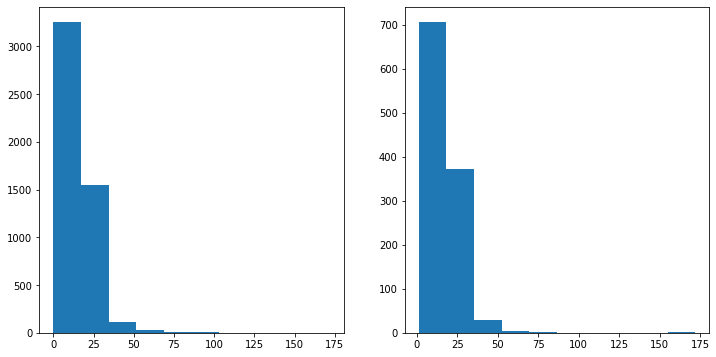

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]


fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 128

In [ ]:
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((4958, 128), (1114, 128))

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 128
EPOCHS=2
BATCH_SIZE=128

In [ ]:

from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense 
from tensorflow.keras import Sequential

vocab_size = VOCAB_SIZE
embedding_dim = EMBED_SIZE
length_size = BATCH_SIZE

first_dropout_rate=0.2
last_dropout_rate = 0.2
units=64

def create_lstm_model(vocab_size, embedding_dim, length_size, first_dropout_rate, last_dropout_rate, units):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=length_size,
                    name='embedding'))
    #droupout layer
    model.add(Dropout(rate=first_dropout_rate))
    #lstm layer
    model.add(LSTM(units=units, name='mylstm'))  # give a name to the layer

    #dropout layer
    model.add(Dropout(rate=last_dropout_rate))

    #output layer
    model.add(Dense(units=1, activation='sigmoid', name='mydense'))  # give a name to the layer
    return model

# create and compile model with 2 LSTM units
model = create_lstm_model(vocab_size, embedding_dim, length_size, first_dropout_rate, last_dropout_rate, units=64)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          1205376   
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 mylstm (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 mydense (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,254,849
Trainable params: 1,254,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(len(X_train))

4958


In [ ]:
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE)

Epoch 1/2
35/35 [==============================] - 13s 291ms/step - loss: 0.4809 - accuracy: 0.7911 - val_loss: 0.3048 - val_accuracy: 0.8528
Epoch 2/2
35/35 [==============================] - 10s 272ms/step - loss: 0.1393 - accuracy: 0.9572 - val_loss: 0.0773 - val_accuracy: 0.9798


In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

35/35 [==============================] - 1s 23ms/step - loss: 0.0531 - accuracy: 0.9838
Accuracy: 98.38%


In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
# print(predictions,X_test)
predictions = ['ham' if item == 0 else 'spam' for item in predictions]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['ham', 'spam']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       946
        spam       0.98      0.91      0.94       168

    accuracy                           0.98      1114
   macro avg       0.98      0.95      0.97      1114
weighted avg       0.98      0.98      0.98      1114



,ham,spam
ham,943,3
spam,15,153
